In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 44s 0us/step


In [0]:
from keras.utils import to_categorical

X_train = X_train / 255
X_test  = X_test / 255

y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2

def build_model():
    net_input = Input(shape=(X_train.shape[1:]))
    
    net_layer = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(net_input)
    net_layer = BatchNormalization()(net_layer)
    net_layer = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = MaxPooling2D((2, 2))(net_layer)
    net_layer = Dropout(0.25)(net_layer)
    
    net_layer = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4))(net_layer)
    net_layer = BatchNormalization()(net_layer)
    net_layer = MaxPooling2D((2, 2))(net_layer)
    net_layer = Dropout(0.25)(net_layer)
    
    net_layer = Flatten()(net_layer)
    
    """
    net_layer = Dense(128, activation='relu')(net_layer)
    net_layer = Dropout(0.5)(net_layer)
    """
    
    net_output = Dense(10, activation='softmax')(net_layer)
    
    model = Model(inputs=net_input, outputs=net_output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
model = build_model()
model_triangular = build_model()
model_triangular2 = build_model()
model_exp_range = build_model()

In [0]:
from keras.callbacks import Callback, K

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        """
        Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):        
        logs = logs or {}
        
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr_triangular = CyclicLR(mode='triangular')
clr_triangular2 = CyclicLR(mode='triangular2')
clr_exp_range = CyclicLR(mode='exp_range', gamma=0.99994)

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=0)
checkpointer_triangular = ModelCheckpoint(filepath='weights_triangular.hdf5', save_best_only=True, verbose=0)
checkpointer_triangular2 = ModelCheckpoint(filepath='weights_triangular2.hdf5', save_best_only=True, verbose=0)
checkpointer_exp_range = ModelCheckpoint(filepath='weights_exp_range.hdf5', save_best_only=True, verbose=0)

In [0]:
batch_size = 64
epochs = 300

In [0]:
training = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                     validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=0)

In [0]:
training_triangular = model_triangular.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                           validation_data=(X_test, y_test), callbacks=[checkpointer_triangular, clr_triangular], verbose=0)

In [0]:
training_triangular2 = model_triangular2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                             validation_data=(X_test, y_test), callbacks=[checkpointer_triangular2, clr_triangular2], verbose=0)

In [0]:
training_exp_range = model_exp_range.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                         validation_data=(X_test, y_test), callbacks=[checkpointer_exp_range, clr_exp_range], verbose=0)

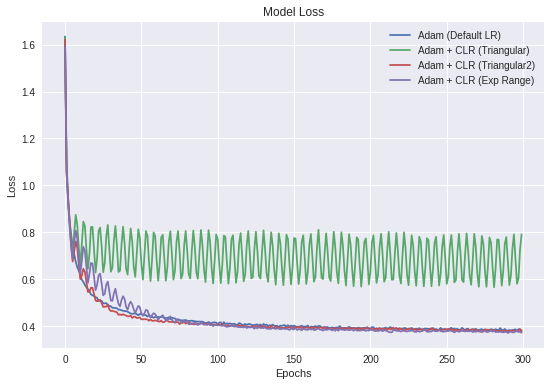

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['loss'], label='Adam (Default LR)')
plt.plot(training.epoch, training_triangular.history['loss'], label='Adam + CLR (Triangular)')
plt.plot(training.epoch, training_triangular2.history['loss'], label='Adam + CLR (Triangular2)')
plt.plot(training.epoch, training_exp_range.history['loss'], label='Adam + CLR (Exp Range)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

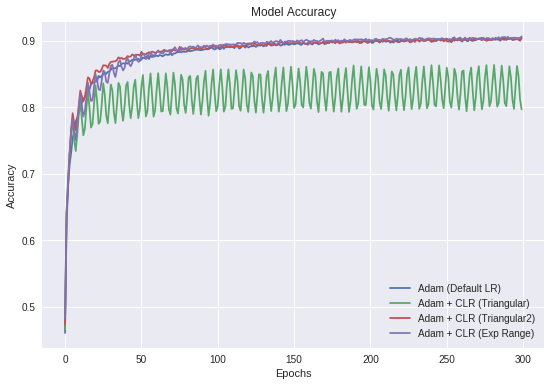

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['acc'], label='Adam (Default LR)')
plt.plot(training.epoch, training_triangular.history['acc'], label='Adam + CLR (Triangular)')
plt.plot(training.epoch, training_triangular2.history['acc'], label='Adam + CLR (Triangular2)')
plt.plot(training.epoch, training_exp_range.history['acc'], label='Adam + CLR (Exp Range)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

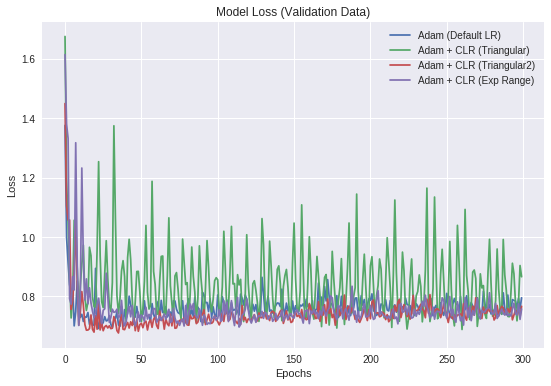

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['val_loss'], label='Adam (Default LR)')
plt.plot(training.epoch, training_triangular.history['val_loss'], label='Adam + CLR (Triangular)')
plt.plot(training.epoch, training_triangular2.history['val_loss'], label='Adam + CLR (Triangular2)')
plt.plot(training.epoch, training_exp_range.history['val_loss'], label='Adam + CLR (Exp Range)')
plt.title('Model Loss (Validation Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

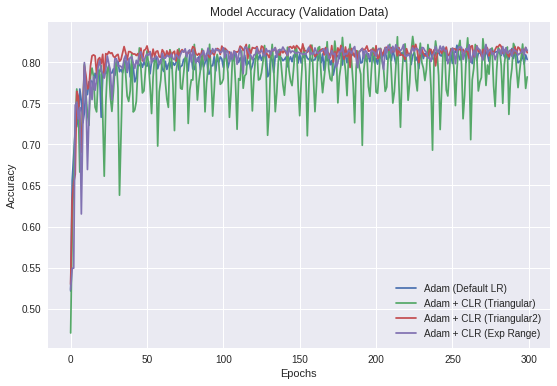

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['val_acc'], label='Adam (Default LR)')
plt.plot(training.epoch, training_triangular.history['val_acc'], label='Adam + CLR (Triangular)')
plt.plot(training.epoch, training_triangular2.history['val_acc'], label='Adam + CLR (Triangular2)')
plt.plot(training.epoch, training_exp_range.history['val_acc'], label='Adam + CLR (Exp Range)')
plt.title('Model Accuracy (Validation Data)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

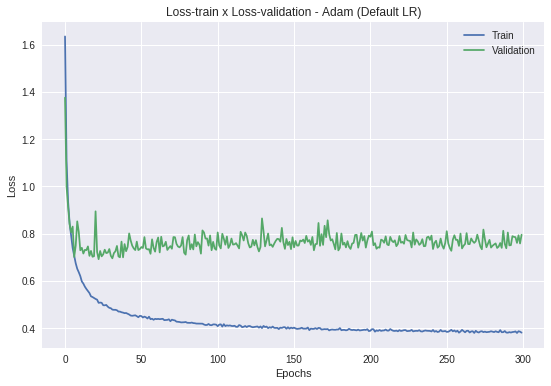

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['loss'], label='Train')
plt.plot(training.epoch, training.history['val_loss'], label='Validation')
plt.title('Loss-train x Loss-validation - Adam (Default LR)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

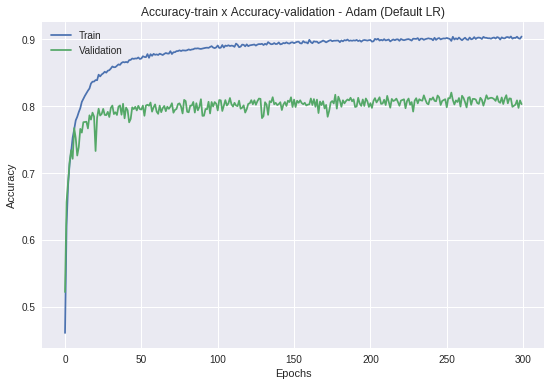

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training.history['acc'], label='Train')
plt.plot(training.epoch, training.history['val_acc'], label='Validation')
plt.title('Accuracy-train x Accuracy-validation - Adam (Default LR)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

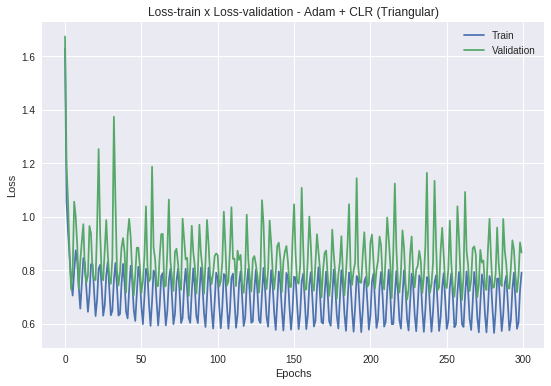

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_triangular.history['loss'], label='Train')
plt.plot(training.epoch, training_triangular.history['val_loss'], label='Validation')
plt.title('Loss-train x Loss-validation - Adam + CLR (Triangular)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

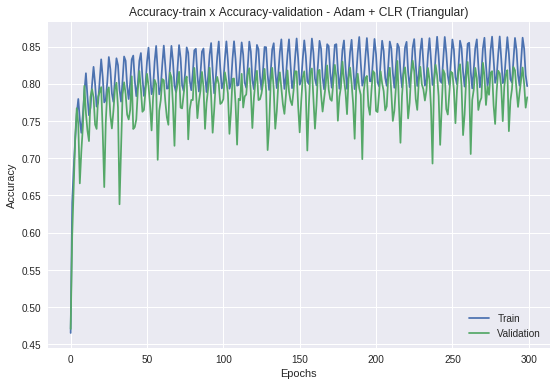

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_triangular.history['acc'], label='Train')
plt.plot(training.epoch, training_triangular.history['val_acc'], label='Validation')
plt.title('Accuracy-train x Accuracy-validation - Adam + CLR (Triangular)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

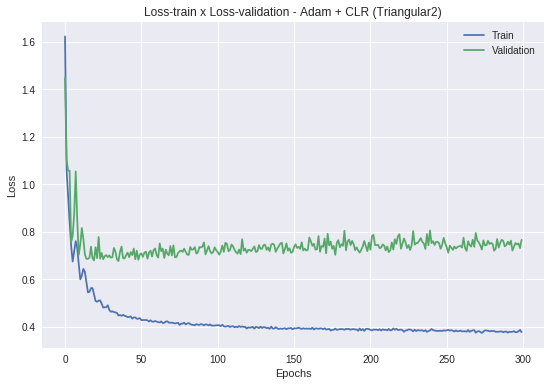

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_triangular2.history['loss'], label='Train')
plt.plot(training.epoch, training_triangular2.history['val_loss'], label='Validation')
plt.title('Loss-train x Loss-validation - Adam + CLR (Triangular2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

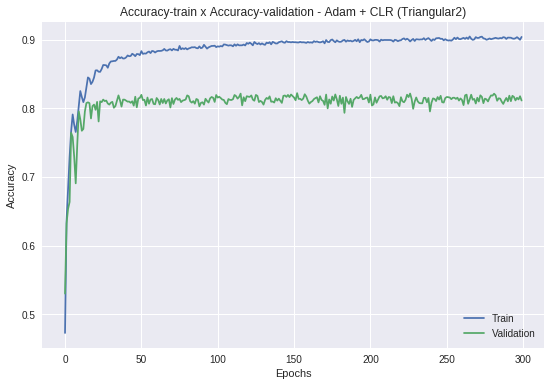

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_triangular2.history['acc'], label='Train')
plt.plot(training.epoch, training_triangular2.history['val_acc'], label='Validation')
plt.title('Accuracy-train x Accuracy-validation - Adam + CLR (Triangular2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

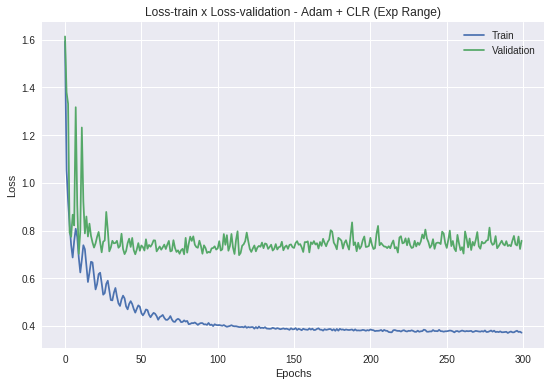

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_exp_range.history['loss'], label='Train')
plt.plot(training.epoch, training_exp_range.history['val_loss'], label='Validation')
plt.title('Loss-train x Loss-validation - Adam + CLR (Exp Range)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

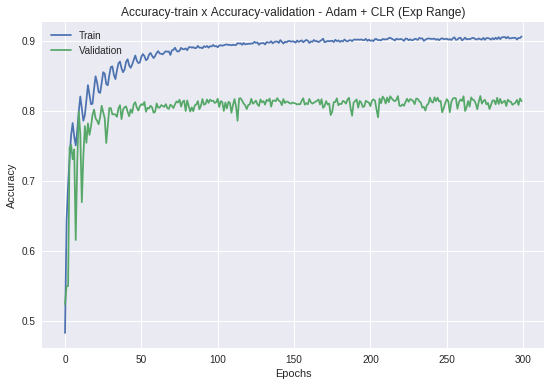

In [0]:
plt.figure(figsize=(9,6))
plt.plot(training.epoch, training_exp_range.history['acc'], label='Train')
plt.plot(training.epoch, training_exp_range.history['val_acc'], label='Validation')
plt.title('Accuracy-train x Accuracy-validation - Adam + CLR (Exp Range)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
training_metrics = {
    'Method': [
        'Adam (Default LR)',
        'Adam + CLR (Triangular)',
        'Adam + CLR (Triangular2)',
        'Adam + CLR (Exp Range)'
    ],
    'Loss Min': [
        min(training.history['loss']),
        min(training_triangular.history['loss']),
        min(training_triangular2.history['loss']),
        min(training_exp_range.history['loss'])
    ],
    'Accuracy Max': [
        max(training.history['acc']),
        max(training_triangular.history['acc']),
        max(training_triangular2.history['acc']),
        max(training_exp_range.history['acc'])
    ]
}

pd.DataFrame(training_metrics)

,Accuracy Max,Loss Min,Method
0,0.90432,0.379179,Adam (Default LR)
1,0.86352,0.564870,Adam + CLR (Triangular)
2,0.90456,0.374366,Adam + CLR (Triangular2)
3,0.90634,0.370393,Adam + CLR (Exp Range)


In [0]:
validation_metrics = {
    'Method': [
        'Adam (Default LR)',
        'Adam + CLR (Triangular)',
        'Adam + CLR (Triangular2)',
        'Adam + CLR (Exp Range)'
    ],
    'Loss Min': [
        min(training.history['val_loss']),
        min(training_triangular.history['val_loss']),
        min(training_triangular2.history['val_loss']),
        min(training_exp_range.history['val_loss'])
    ],
    'Accuracy Max': [
        max(training.history['val_acc']),
        max(training_triangular.history['val_acc']),
        max(training_triangular2.history['val_acc']),
        max(training_exp_range.history['val_acc'])
    ]
}

pd.DataFrame(validation_metrics)

,Accuracy Max,Loss Min,Method
0,0.8203,0.691637,Adam (Default LR)
1,0.8310,0.688478,Adam + CLR (Triangular)
2,0.8220,0.676826,Adam + CLR (Triangular2)
3,0.8213,0.696748,Adam + CLR (Exp Range)
